### Домашнее задание <a class="anchor" id="hw"></a><center>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [47]:
# Расчет прироста

def gain(left_labels, right_labels, root_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [48]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [49]:
def predict_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

In [50]:
def predict(data, tree):
    
    preds = []
    for obj in data:
        prediction = predict_object(obj, tree)
        preds.append(prediction)
    return preds

In [51]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

**1. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.**

In [52]:
# сгенерируем данные
data, targets = make_regression(n_features=2, n_informative=2, random_state=5)

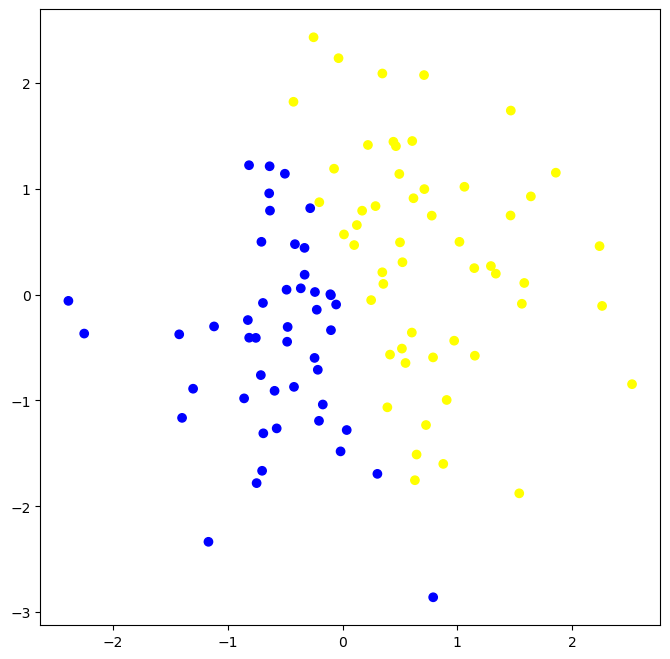

In [53]:
# визуализируем сгенерированные данные
from matplotlib.colors import ListedColormap
colors = ListedColormap(['blue', 'yellow'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data)), 
              c=targets, cmap=colors)

In [54]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data_regr, test_data_regr, train_target_regr, test_target_regr = train_test_split(data, 
                                                                                        targets, 
                                                                                        test_size=0.3,
                                                                                        random_state=1)

In [55]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean()

In [56]:
def mse(targets):
    return np.mean((targets - targets.mean())**2)

In [57]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 7

    root_mse = mse(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_targets, false_targets, root_mse, mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [58]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target):

    gain, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target)

    false_branch = build_tree(false_data, false_target)

    node = Node(index, t, true_branch, false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return node

In [60]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data_regr, train_target_regr)
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.10061434630710828
--> True:
  Индекс 0
  Порог -0.8568531547160899
  --> True:
    Прогноз: -109.75655471490919
  --> False:
    Индекс 0
    Порог -0.5732155560138283
    --> True:
      Прогноз: -54.35634172577482
    --> False:
      Индекс 1
      Порог -0.0061949084857593475
      --> True:
        Прогноз: -24.14333579981145
      --> False:
        Прогноз: -10.497293009470326
--> False:
  Индекс 0
  Порог 0.9068894675659355
  --> True:
    Индекс 1
    Порог 0.6566194702604272
    --> True:
      Индекс 0
      Порог 0.41367880834311616
      --> True:
        Прогноз: 11.692317397311196
      --> False:
        Прогноз: 26.124460117553248
    --> False:
      Прогноз: 51.734190251511706
  --> False:
    Прогноз: 100.46772793345458


In [61]:
from sklearn.metrics import r2_score

train_answers = predict(train_data_regr, my_tree)
train_r2 = r2_score(train_target_regr, train_answers)
print(train_r2)

answers = predict(test_data_regr, my_tree)
test_r2 = r2_score(test_target_regr, answers)
print(test_r2)

0.9175577195677374
0.8175496005209346
